<a href="https://colab.research.google.com/github/harshinip185/Bio-Imaging-Project/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Bio-Imaging-2024-25/

/content/drive/.shortcut-targets-by-id/1pBoZiWReyM4Pycyz1ExzYOr8BO_-TGhn/Bio-Imaging-2024-25


In [ ]:
%ls

archive/  chest_xray_dataset.zip  data/


In [ ]:
!nvidia-smi

Wed Apr  9 09:18:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# ---------------------- # PHASE 1: Setup and Dataset # ---------------------- #

In [ ]:
# # DO NOT RUN THIS; unless setting up data
# # Requires archive.zip file downloaded from https://www.kaggle.com/competitions/titanic/data
# %%capture
# !mkdir archive/
# !unzip chest_xray_dataset.zip -d archive/

In [ ]:
# # Move necessary data to the "data" directory for further processing and training
# %%capture
# !mkdir data/
# !mv archive/chest_xray/train data/
# !mv archive/chest_xray/test data/
# !mv archive/chest_xray/val data/

In [ ]:
# Data-split and distribution
import os

for folder in os.listdir("./data"):
  print("-"*50)
  print(folder.upper(), "data")
  for sub_folder in os.listdir(f"./data/{folder}"):
      print(sub_folder, len(os.listdir(f"./data/{folder}/{sub_folder}")))

--------------------------------------------------
TEST data
NORMAL 234
PNEUMONIA 390
--------------------------------------------------
TRAIN data
NORMAL 1341
PNEUMONIA 3875
--------------------------------------------------
VAL data
NORMAL 8
PNEUMONIA 8


In [ ]:
# ---------------------- # PHASE 2: Define Transformations # ---------------------- #

In [ ]:
from torchvision import transforms
import cv2
import numpy as np
import PIL.Image as Image

class CLAHEContrastBoost(object):
    def __call__(self, img):
        if not isinstance(img, Image.Image):
            raise TypeError("Input must be a PIL Image")

        if img.mode != 'L':
            img = img.convert('L')

        img_np = np.array(img)

        if img_np.dtype != np.uint8:
            if img_np.dtype == np.float32 or img_np.dtype == np.float64:
                img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
            else:
                img_np = img_np.astype(np.uint8)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(img_np)

        return Image.fromarray(clahe_img, mode='L')

class ImageSharpening:
    def __call__(self, img):
        if img.mode != 'L':
            img = img.convert('L')  # convert to grayscale
        img = np.array(img)
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        sharp = cv2.filter2D(img, -1, kernel)
        return Image.fromarray(sharp, mode='L')

# --- Base & Augmented Transforms ---
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

augmentations = [
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0))
]

def with_augment(*ops):
    return transforms.Compose([
        *ops,
        *augmentations,
        transforms.ToTensor()
    ])

# --- Transform Versions ---
transform_versions = {
    'baseline': base_transform,
    'clahe': with_augment(CLAHEContrastBoost(), transforms.Resize((224, 224))),
    'sharpen': with_augment(ImageSharpening(), transforms.Resize((224, 224))),
    'hist_eq': with_augment(
        transforms.Grayscale(num_output_channels=1),
        transforms.Lambda(lambda x: Image.fromarray(
            cv2.equalizeHist(np.array(x.convert('L'))), mode='L')),
        transforms.Resize((224, 224))
    )
}

In [ ]:
# ---------------------- # get class weights # ---------------------- #

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(dataset):
    targets = [sample[1] for sample in dataset.samples]
    counts = Counter(targets)
    total = sum(counts.values())
    weights = [total / counts[i] for i in range(len(counts))]
    return torch.tensor(weights, dtype=torch.float)

In [ ]:
# ---------------------- # PHASE 3: Dataset Loader # ---------------------- #

In [ ]:
from collections import Counter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler

def get_dataloaders(transform, batch_size=8):
    train_ds = ImageFolder('data/train', transform=transform)
    val_ds = ImageFolder('data/val', transform=transform)
    test_ds = ImageFolder('data/test', transform=transform)

    # Compute class weights
    class_counts = Counter([y for _, y in train_ds.samples])
    class_weights = [1.0 / class_counts[y] for _, y in train_ds.samples]
    sampler = WeightedRandomSampler(class_weights, len(class_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)
    return train_loader, val_loader, test_loader, train_ds

In [ ]:
# ---------------------- # compare all transforms # ---------------------- #

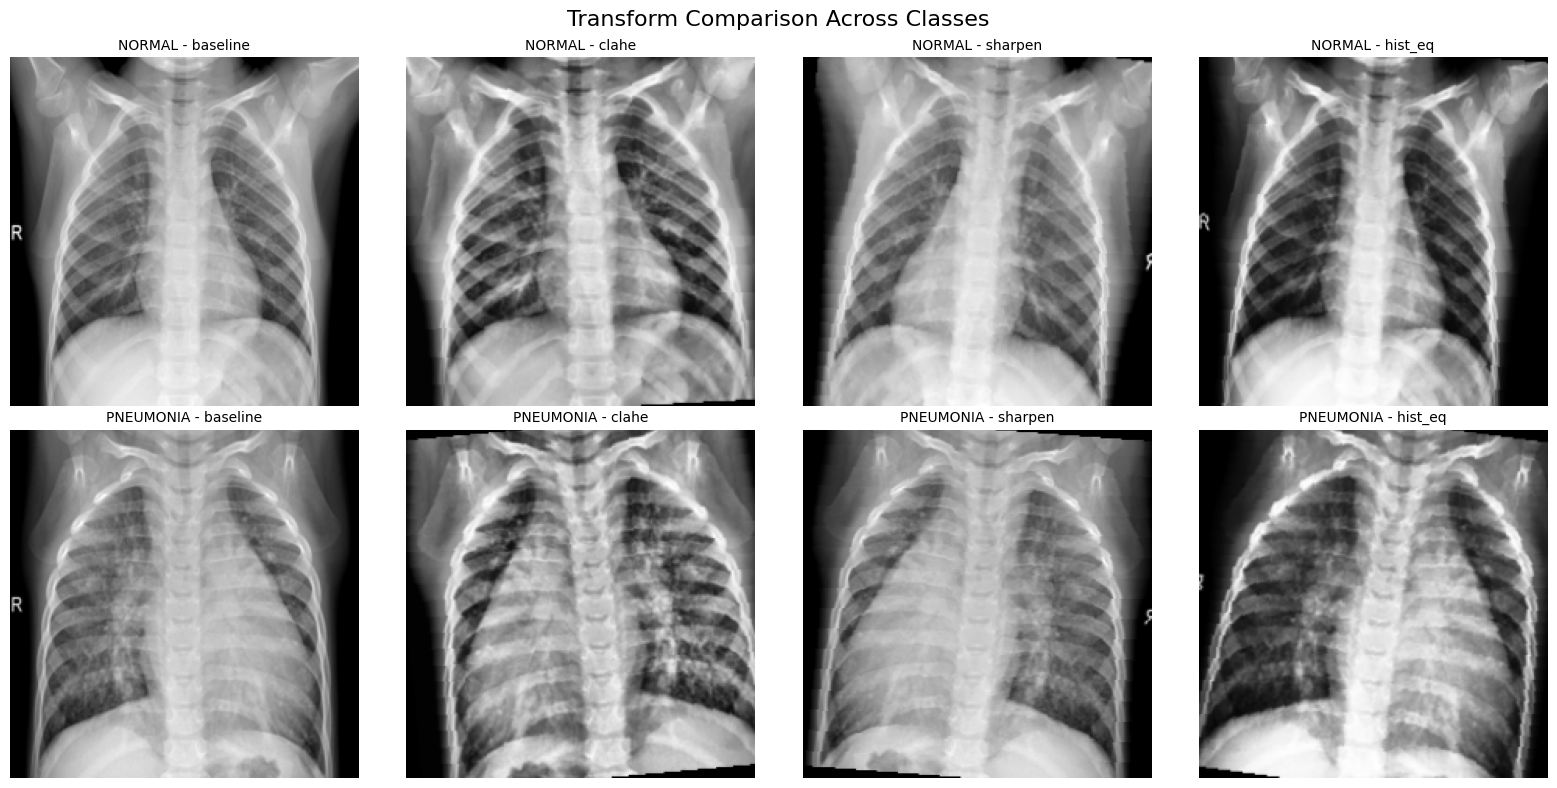

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
import os

# Base path
base_path = 'data/train'

# Get class names (subfolder names)
classes = os.listdir(base_path)  # ['NORMAL', 'PNEUMONIA']
classes.sort()  # just to keep consistent order

# Create a mapping: class name → one image path (first image in the class folder)
sample_paths = {}
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    for fname in os.listdir(cls_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            sample_paths[cls] = os.path.join(cls_path, fname)
            break  # take the first image

# Plotting
num_classes = len(classes)
num_transforms = len(transform_versions)

fig, axs = plt.subplots(num_classes, num_transforms, figsize=(4 * num_transforms, 4 * num_classes))

for row, (cls_name, img_path) in enumerate(sample_paths.items()):
    for col, (trans_name, transform) in enumerate(transform_versions.items()):
        # Load image with PIL
        img = Image.open(img_path)
        transformed = transform(img)

        # Handle subplot layout for 1 row or 1 column edge cases
        ax = axs[row][col] if num_classes > 1 else axs[col]

        # Plot
        ax.imshow(TF.to_pil_image(transformed), cmap='gray')
        ax.set_title(f"{cls_name} - {trans_name}", fontsize=10)
        ax.axis('off')

plt.suptitle("Transform Comparison Across Classes", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# ---------------------- # PHASE 4: CNN Model # ---------------------- #

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

def build_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    for name, param in model.named_parameters():
        if name.startswith('layer4') or name.startswith('fc'):
            param.requires_grad = True
        else:
            param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

In [ ]:
# ---------------------- # PHASE 5: Training Loop # ---------------------- #

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, roc_auc_score

def train_model(model, train_loader, val_loader, class_weights, epochs=5, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} started")
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

    return model

In [ ]:
# ---------------------- # PHASE 6: Evaluation Function # ---------------------- #

In [ ]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds += torch.argmax(outputs, dim=1).cpu().numpy().tolist()
            trues += labels.numpy().tolist()
    print(classification_report(trues, preds))

In [ ]:
# ---------------------- # PHASE 7: Run Experiments # ---------------------- #

In [ ]:
results = {}
for name, transform in transform_versions.items():
    print(f"\nTraining with: {name}")
    train_loader, val_loader, test_loader, train_ds = get_dataloaders(transform)
    model = build_model()
    class_weights = get_class_weights(train_ds)
    trained_model = train_model(model, train_loader, val_loader, class_weights)
    print(f"Evaluating model trained with: {name}")
    evaluate_model(trained_model, test_loader)
    results[name] = trained_model


Training with: baseline
Epoch 1 started
Epoch [1/5], Step [0/652], Loss: 1.0525
Epoch [1/5], Step [100/652], Loss: 0.0273
Epoch [1/5], Step [200/652], Loss: 0.0239
Epoch [1/5], Step [300/652], Loss: 0.0422
Epoch [1/5], Step [400/652], Loss: 0.0124
Epoch [1/5], Step [500/652], Loss: 0.0402
Epoch [1/5], Step [600/652], Loss: 0.5244
Epoch 2 started
Epoch [2/5], Step [0/652], Loss: 0.0543
Epoch [2/5], Step [100/652], Loss: 0.0221
Epoch [2/5], Step [200/652], Loss: 0.0283
Epoch [2/5], Step [300/652], Loss: 0.0086
Epoch [2/5], Step [400/652], Loss: 0.0047
Epoch [2/5], Step [500/652], Loss: 0.0282
Epoch [2/5], Step [600/652], Loss: 0.0136
Epoch 3 started
Epoch [3/5], Step [0/652], Loss: 0.0075
Epoch [3/5], Step [100/652], Loss: 0.1602
Epoch [3/5], Step [200/652], Loss: 0.0028
Epoch [3/5], Step [300/652], Loss: 0.0114
Epoch [3/5], Step [400/652], Loss: 0.0012
Epoch [3/5], Step [500/652], Loss: 0.0650
Epoch [3/5], Step [600/652], Loss: 0.0030
Epoch 4 started
Epoch [4/5], Step [0/652], Loss: 0.

In [ ]:
# ---------------------- # PHASE 8:Post-Training Analysis # ---------------------- #

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_metrics(model, dataloader, device="cuda"):
    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            predictions = torch.argmax(outputs, dim=1)

            preds += predictions.cpu().numpy().tolist()
            trues += labels.numpy().tolist()
            probs += probabilities.cpu().numpy().tolist()

    return {
        "Accuracy": accuracy_score(trues, preds),
        "Precision": precision_score(trues, preds),
        "Recall": recall_score(trues, preds),
        "F1 Score": f1_score(trues, preds),
        "AUC": roc_auc_score(trues, probs)
    }

In [ ]:
import pandas as pd

metrics_summary = {}
for name, model in results.items():
    metrics_summary[name] = get_metrics(model, test_loader)

df_metrics = pd.DataFrame(metrics_summary).T
print(df_metrics)

          Accuracy  Precision    Recall  F1 Score       AUC
baseline  0.725962   0.706215  0.961538  0.814332  0.797250
clahe     0.838141   0.801670  0.984615  0.883774  0.951298
sharpen   0.895833   0.911392  0.923077  0.917197  0.956279
hist_eq   0.881410   0.849558  0.984615  0.912114  0.964771


In [ ]:
# ---------------------- # PHASE 9:Visualization # ---------------------- #

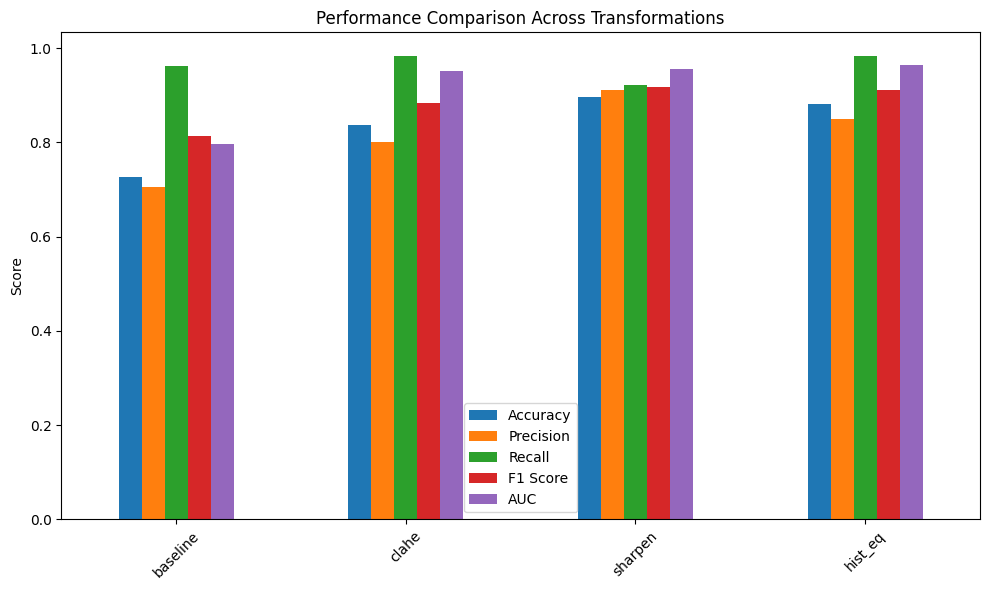

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot metrics
df_metrics.plot(kind="bar", figsize=(10, 6))
plt.title("Performance Comparison Across Transformations")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ---------------------- # PHASE 10:Hypothesis Testing # ---------------------- #

In [ ]:
from tqdm import tqdm

def get_metric_across_runs(model_key, num_runs=5):
    scores = []
    for _ in tqdm(range(num_runs), total=num_runs):
        metrics = get_metrics(results[model_key], test_loader)
        scores.append(metrics["Accuracy"])  # Or "F1 Score", etc.
    return scores

In [ ]:
num_runs = 5  # or more for better power

acc_baseline = get_metric_across_runs("baseline", num_runs)
acc_clahe = get_metric_across_runs("clahe", num_runs)
acc_sharpen = get_metric_across_runs("sharpen", num_runs)
acc_hist_eq = get_metric_across_runs("hist_eq", num_runs)

100%|██████████| 5/5 [01:03<00:00, 12.70s/it]


In [ ]:
from scipy.stats import ttest_rel

def run_ttest(name, acc_other):
    t_stat, p_val = ttest_rel(acc_baseline, acc_other)
    print(f"\nT-test: baseline vs {name}")
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("✅ Statistically significant")
    else:
        print("❌ Not statistically significant")

run_ttest("clahe", acc_clahe)
run_ttest("sharpen", acc_sharpen)
run_ttest("hist_eq", acc_hist_eq)


T-test: baseline vs clahe
t-statistic: -14.9108, p-value: 0.0001
✅ Statistically significant

T-test: baseline vs sharpen
t-statistic: -29.2928, p-value: 0.0000
✅ Statistically significant

T-test: baseline vs hist_eq
t-statistic: -15.4185, p-value: 0.0001
✅ Statistically significant
